In [1]:
%matplotlib inline
import numpy as np
import seaborn
from scipy.stats import linregress
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Load the data from Excel, remove data points that are not comparable.
raw_kin_df = pd.read_excel('01152018rubisco_kinetics.xlsx', index_col=0)
wt_only_df = raw_kin_df[raw_kin_df.mutant == False]

# Filtered DataFrame used for most plots below.
# Only variants with all the data
kin_df = wt_only_df.copy()
has_KMs = np.logical_and(np.isfinite(kin_df.Kc), np.isfinite(kin_df.Ko))
has_kcats = np.logical_and(np.isfinite(kin_df.Vc), np.isfinite(kin_df.Vo))
has_kons = np.logical_and(np.isfinite(kin_df.kon_C), np.isfinite(kin_df.kon_O))
has_all = np.logical_and(np.logical_and(has_KMs, has_kcats), has_kons)
kin_df = kin_df[has_all]

# Some measurements are made at much higher temps and are not comparable.
# TODO: collect pH of measurements so we can restrict to similar range
high_T = kin_df.Temp_C > 30
kin_df = kin_df.loc[np.logical_not(high_T)]

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_df = kin_df[kin_df.savir]
nonsavir_df = kin_df[kin_df.savir == False]

# Group by RuBisCO form
grouped_form = kin_df.groupby('form_text')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

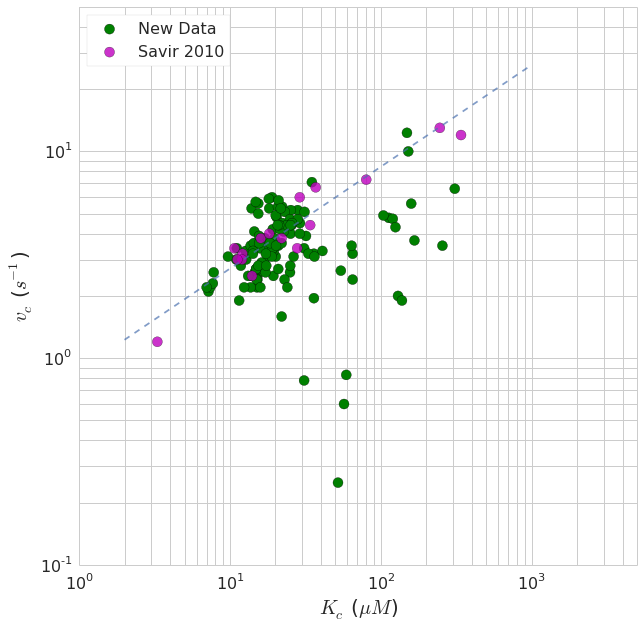

In [3]:
# Plot 1: Data from Savir separate from new data.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

# Note - axes are reversed from the Savir paper so above the line = good.
plt.scatter(nonsavir_df.Kc, nonsavir_df.Vc, c='g', s=100, label='New Data')
plt.scatter(savir_df.Kc, savir_df.Vc, c='m', s=100, label='Savir 2010', alpha=0.8)

# Plot Savir's power law for Kc vs. Vc
# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

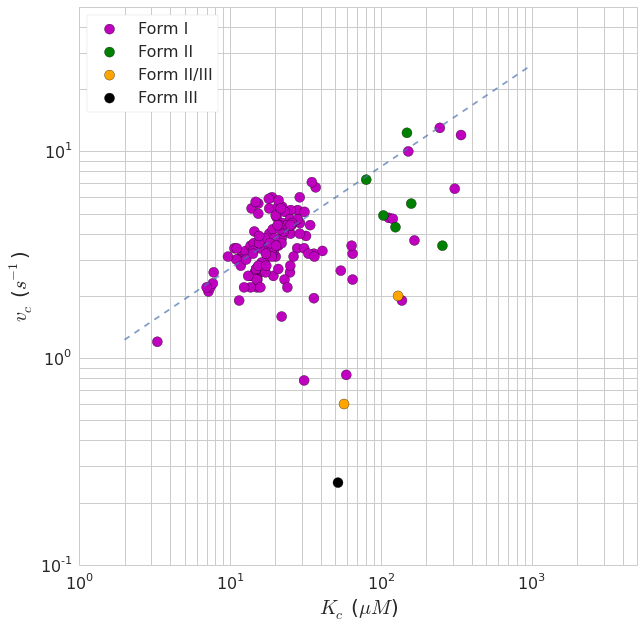

In [4]:
# Plot Kc vs. Vc coloring by RuBisCO form.
# Note that a lot of the spread in the Form II measurements is due to the spread of Rubrum data in the dataset.
# We included these data points on purpose, but they make the correlations look weaker of course.
# Need to dig through the data and see which numbers were measured in a trustworthy fashion.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = ['m', 'g', 'orange', 'k']
for i, (group, gdf) in enumerate(grouped_form):
    label = 'Form %s' % group
    c = colors[i]
    plt.scatter(gdf.Kc, gdf.Vc, c=c, s=100, label=label)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

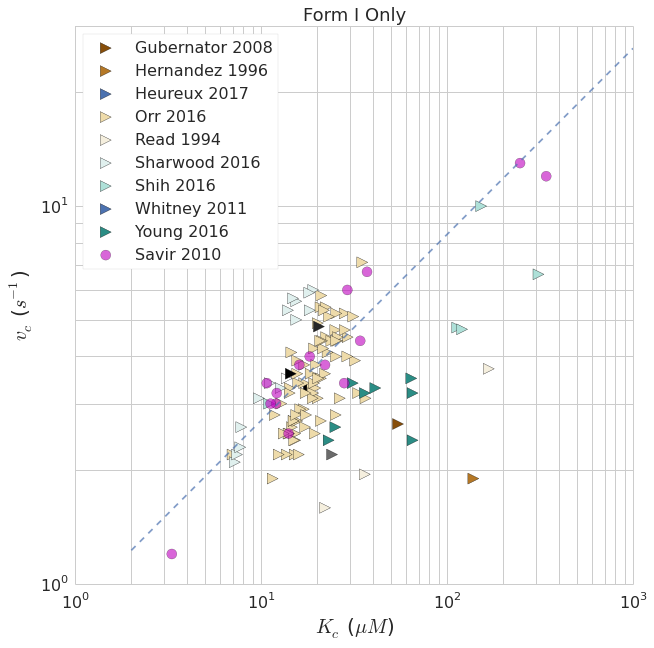

In [5]:
# Plot Kc vs. Vc for FI RuBisCOs alone, coloring by reference.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 10)
fIs = grouped_form.get_group('I')
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    l = group
    c = colors[i]
    plt.scatter(gdf.Kc, gdf.Vc, c=c, s=120, marker='>', label=l)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.Kc, savir_FIs.Vc, c='m', s=100, alpha=0.6, label='Savir 2010')

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.title('Form I Only', fontsize=18)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e0, 30)
plt.xlim(1, 1e3)

plt.show()

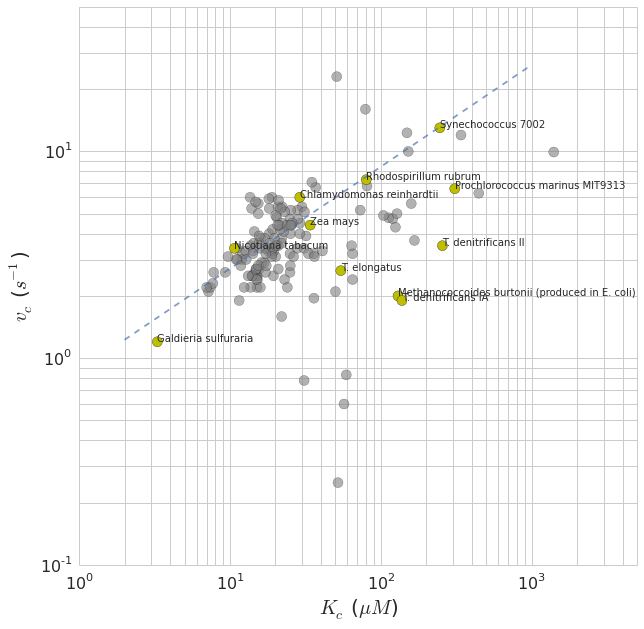

In [6]:
# Annotate "interesting" RuBisCOs, demarcated in the spreadsheet.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

# Group by manually curated "interesting" category mostly for famous RuBisCO isoforms
grouped_interesting = wt_only_df.groupby('interesting')
interesting = grouped_interesting.get_group(True)
others = grouped_interesting.get_group(False)

plt.scatter(others.Kc, others.Vc, c='grey', s=100, alpha=0.6)
plt.scatter(interesting.Kc, interesting.Vc, c='y', s=100)

# Comment out this loop for text-free diagram.
for i in interesting.index:
    r = interesting.loc[i]
    plt.text(r.Kc, r.Vc, i)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

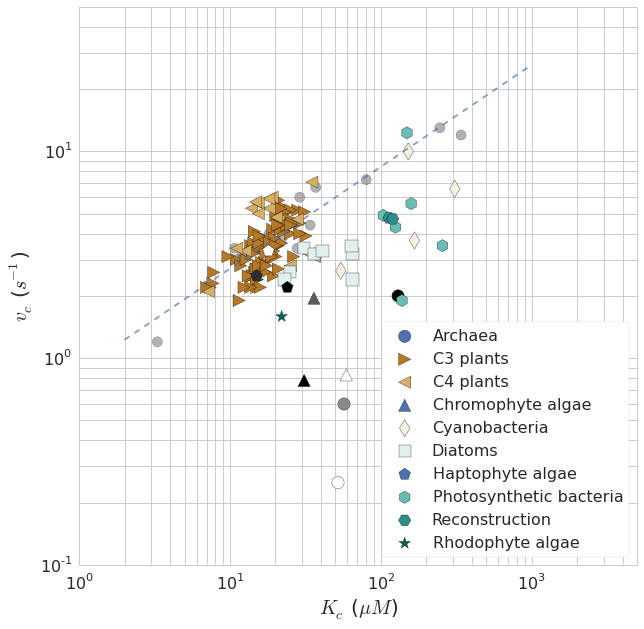

In [7]:
# Kc vs. Vc - show new data by taxonomic grouping of the organism. 
# Notice again the wide spread in photosynthetic bacteria being due to the
# very large deviations in measurements for the Rubrum FII enzyme.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

grouped_taxon = nonsavir_df.groupby('Taxonomy')

plt.scatter(savir_df.Kc, savir_df.Vc, c='grey', s=100, alpha=0.6)

for i, (group, gdf) in enumerate(grouped_taxon):
    marker = markers[i % len(markers)]
    c = colors[i % len(colors)]
    plt.scatter(gdf.Kc, gdf.Vc, label=group, s=150, c=c, marker=marker)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=4, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

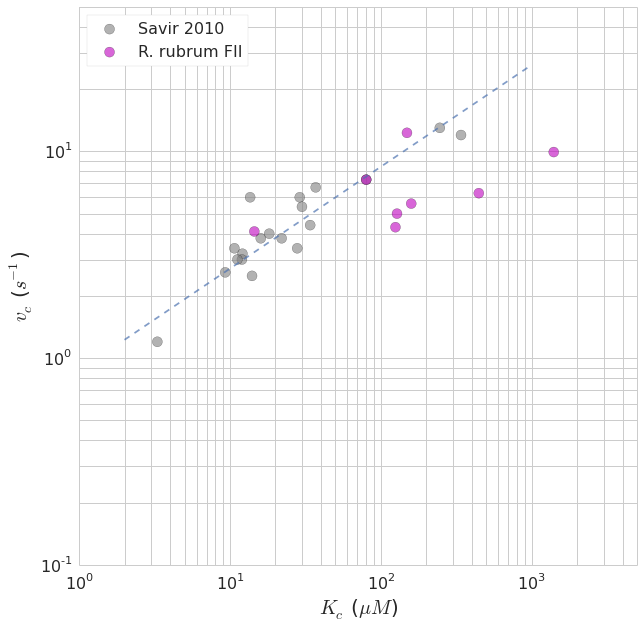

In [8]:
# Highlight the variation in the Rubrum FII measurements on Kc vs. Vc plot.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

rubrums = wt_only_df.index.str.match('.*rubrum.*', case=False)
rubrums = wt_only_df.loc[rubrums]
savir_all_df = wt_only_df[wt_only_df.savir == True]

plt.scatter(savir_all_df.Kc, savir_all_df.Vc, c='grey', s=100, alpha=0.6, label='Savir 2010')
plt.scatter(rubrums.Kc, rubrums.Vc, c='m', s=100, alpha=0.6, label='R. rubrum FII')

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

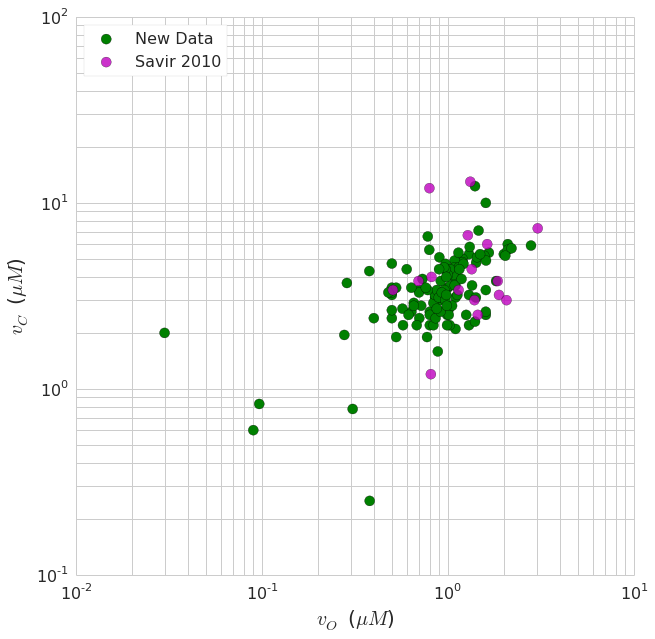

In [9]:
# Is vO still uncorrelated with vC as suggested by Savir2010?
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

plt.scatter(nonsavir_df.Vo, nonsavir_df.Vc, c='g', s=100, label='New Data')
plt.scatter(savir_df.Vo, savir_df.Vc, c='m', s=100, label='Savir 2010', alpha=0.8)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$v_O$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_C$ ($\mu M$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

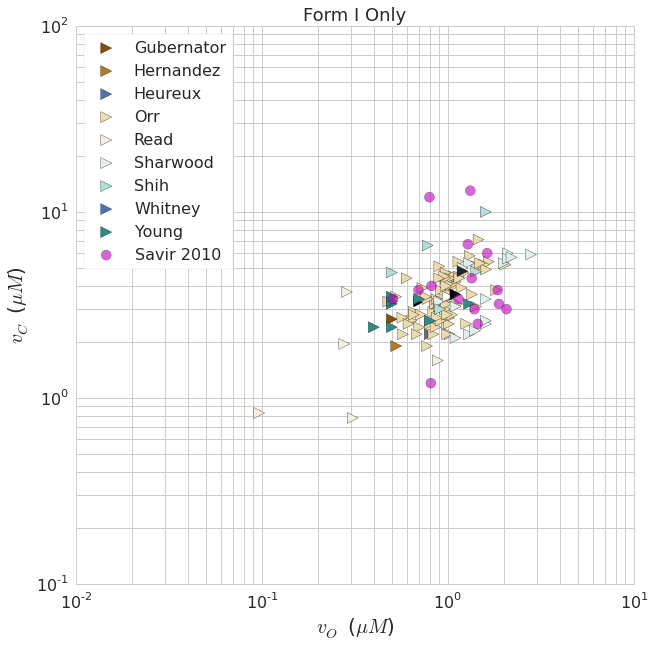

In [10]:
# Vo vs Vc but for FI enzymes only.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 10)
fIs = grouped_form.get_group('I')
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    l = group.split()[0]
    c = colors[i]
    plt.scatter(gdf.Vo, gdf.Vc, c=c, s=120, marker='>', label=l)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.Vo, savir_FIs.Vc, c='m', s=100, alpha=0.6, label='Savir 2010')

plt.legend(loc=2, fontsize=16, frameon=True)
plt.title('Form I Only', fontsize=18)
plt.xlabel('$v_O$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_C$ ($\mu M$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

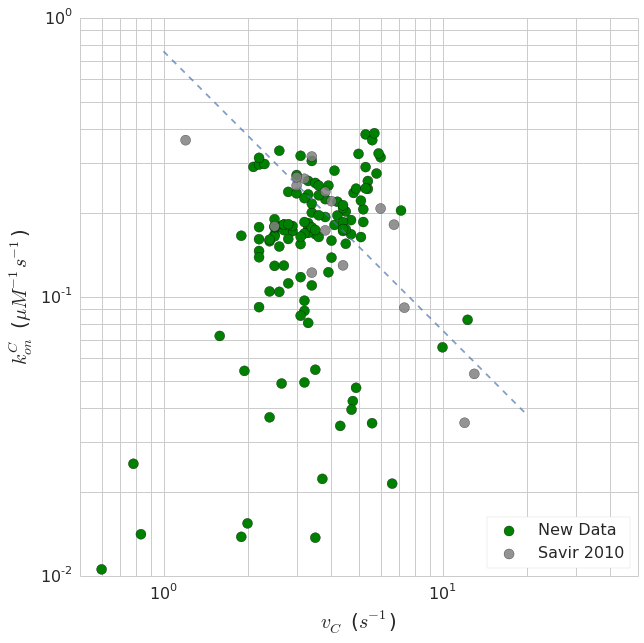

In [11]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC graph.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

plt.scatter(nonsavir_df.Vc, nonsavir_df.kon_C, c='g', s=100, label='New Data')
plt.scatter(savir_df.Vc, savir_df.kon_C, c='grey', s=100, alpha=0.85, label='Savir 2010')

# Savir 2010 says konC = vc/KC = vc/(1.32*vc^2) = 0.757/vc
xs = np.arange(1, 20, 0.1)
projected_konC = 0.757/xs
plt.plot(xs, projected_konC, ls='--', alpha=0.7)

plt.legend(loc=4, fontsize=16, frameon=True)
plt.xlabel('$v_C$ ($s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-2, 1)
plt.xlim(0.5, 50)

plt.show()

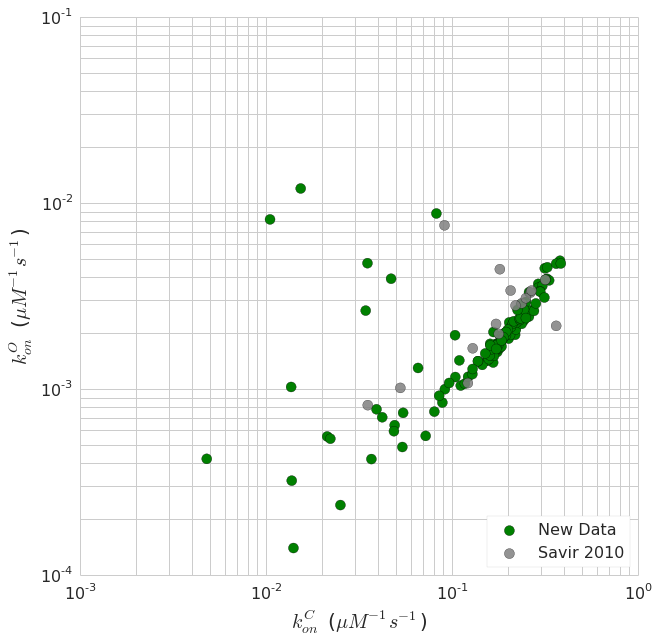

In [12]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

plt.scatter(nonsavir_df.kon_C, nonsavir_df.kon_O, c='g', s=100, label='New Data')
plt.scatter(savir_df.kon_C, savir_df.kon_O, c='grey', s=100, alpha=0.85, label='Savir 2010')

# NOTE: can't find the prefactor for this power law in the paper. 
# Can recalculate by doing regression from the Savir data but didn't have time before presentation. 
# Would prefer to calculate from numbers reported in the PNAS paper. Probably possible, will take some thought.

plt.legend(loc=4, fontsize=16, frameon=True)
plt.xlabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-4, .1)
plt.xlim(1e-3, 1)

plt.show()

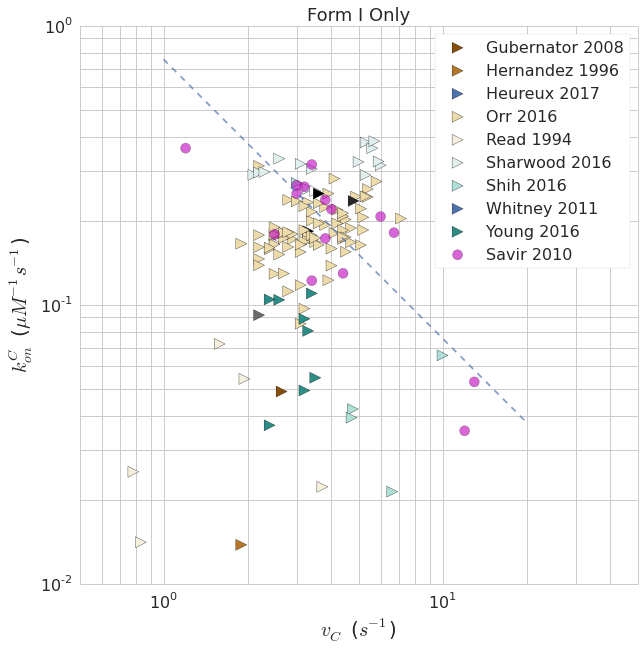

In [13]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC only for FI enzymes, color by reference
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 10)
fIs = grouped_form.get_group('I')
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.Vc, gdf.kon_C, c=c, s=120, marker='>', label=group)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.Vc, savir_FIs.kon_C, c='m', s=100, alpha=0.6, label='Savir 2010')

# Savir 2010 says konC = vc/KC = vc/(1.32*vc^2) = 0.757/vc
xs = np.arange(1, 20, 0.1)
projected_konC = 0.757/xs
plt.plot(xs, projected_konC, ls='--', alpha=0.7)

plt.title('Form I Only', fontsize=18)
plt.legend(loc=1, fontsize=16, frameon=True)
plt.xlabel('$v_C$ ($s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-2, 1)
plt.xlim(0.5, 50)

plt.show()

In [19]:
# For mechanistic proposal 2
# Attempt to fit a power law at the boundary by taking data from the refs that make up the boundary
refs = [u'Sharwood 2016', u'Young 2016', u'Read 1994', u'Heureux 2017',  u'Orr 2016']
fIs = grouped_form.get_group('I')
only_refs = fIs[fIs.short_ref.isin(refs)]

sample_xs = np.log(only_refs.kon_C)
sample_ys = np.log(only_refs.kon_O)

# TODO: should be doing this with robust regression because we expect asymmetric outliers
# biased to the left of the curve. This will do for now to illustrate significance, 
# but I would not trust the exponent, as is evident in the plot below. 
slope, intercept, r_val, p_val, stderr = linregress(sample_xs, sample_ys)
r2 = r_val**2
print 'ln(y) = %.2g ln(x) + %.2g; R = %.2f; P = %.2g' % (slope, intercept, r_val, p_val)
print 'stderr', stderr

# Power law
prefactor = np.exp(intercept)
exponent = slope
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)
konCs = np.arange(1e-2, 1, 0.001)
predicted_konOs = prefactor * np.power(konCs, exponent)

ln(y) = 0.98 ln(x) + -4.6; R = 0.96; P = 2.8e-61
stderr 0.0264731228796
y = 0.01 x^(0.979)


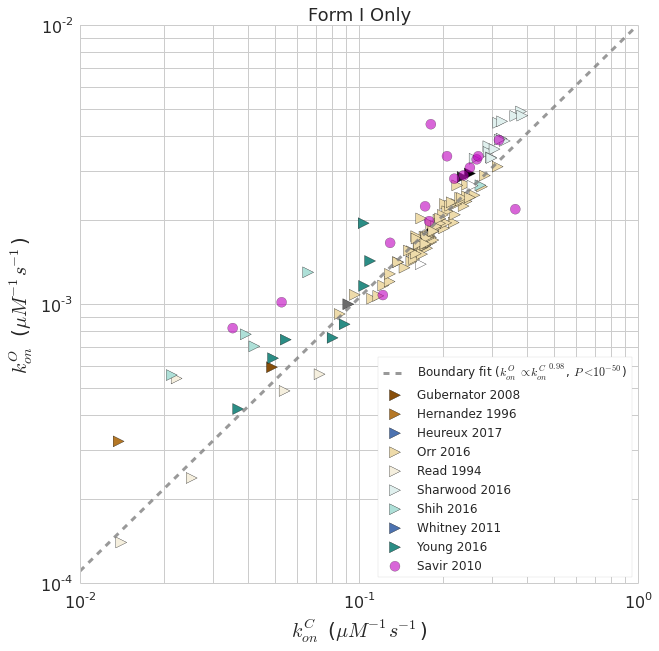

In [20]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO only for FI enzymes, color by reference
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 10)
fIs = grouped_form.get_group('I')
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.kon_C, gdf.kon_O, c=c, s=120, marker='>', label=group)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.kon_C, savir_FIs.kon_O, c='m', s=100, alpha=0.6, label='Savir 2010')

fit_label = 'Boundary fit ($k_{on}^O \\propto {k_{on}^C}^{%.2f}$, $P < 10^{-50}$)' % exponent
plt.plot(konCs, predicted_konOs, ls='--', c='grey', lw=3, alpha=0.8, label=fit_label)

plt.title('Form I Only', fontsize=18)
plt.legend(loc=4, fontsize=12, frameon=True)
plt.xlabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-4, 1e-2)
plt.xlim(1e-2, 1)

plt.show()

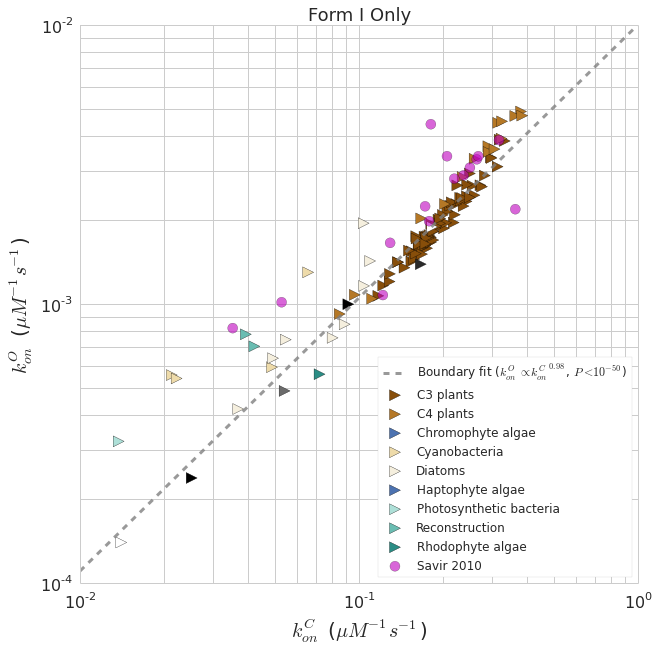

In [22]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO only for FI enzymes, color by reference
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 10)
fIs = grouped_form.get_group('I')
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('Taxonomy')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.kon_C, gdf.kon_O, c=c, s=120, marker='>', label=group)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.kon_C, savir_FIs.kon_O, c='m', s=100, alpha=0.6, label='Savir 2010')

fit_label = 'Boundary fit ($k_{on}^O \\propto {k_{on}^C}^{%.2f}$, $P < 10^{-50}$)' % exponent
plt.plot(konCs, predicted_konOs, ls='--', c='grey', lw=3, alpha=0.8, label=fit_label)

plt.title('Form I Only', fontsize=18)
plt.legend(loc=4, fontsize=12, frameon=True)
plt.xlabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-4, 1e-2)
plt.xlim(1e-2, 1)

plt.show()